In [1]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec, ticker

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

In [2]:
SCORES_FILE = "../../results/shaping-eval/tamaraw/scores.csv"
OUTPUT_FILE = pathlib.Path("/tmp/plot.png")
MIN_PKT_SIZE = 0
WITH_LEGEND = True

if "snakemake" in globals():
    SCORES_FILE = snakemake.input[0]
    OUTPUT_FILE = pathlib.Path(snakemake.output[0])
    MIN_PKT_SIZE = snakemake.params.get("min_pkt_size", 0)
    WITH_LEGEND = snakemake.params.get("with_legend", False)

In [3]:
data = pd.melt(pd.read_csv(SCORES_FILE), id_vars=["sample", "rate", "dir", "min_pkt_size"], var_name="metric")
data = data[data["min_pkt_size"] == MIN_PKT_SIZE]
data

,sample,rate,dir,min_pkt_size,metric,value
0,results/shaping-eval/tamaraw/dataset/0000/0_0,1ms,in,0,pearsonr,0.119070
2,results/shaping-eval/tamaraw/dataset/0000/0_0,1ms,out,0,pearsonr,-0.036511
4,results/shaping-eval/tamaraw/dataset/0000/0_0,5ms,in,0,pearsonr,0.633462
6,results/shaping-eval/tamaraw/dataset/0000/0_0,5ms,out,0,pearsonr,0.323084
8,results/shaping-eval/tamaraw/dataset/0000/0_0,25ms,in,0,pearsonr,0.906700
...,...,...,...,...,...,...
31990,results/shaping-eval/tamaraw/dataset/0789/1_0,5ms,out,0,euclidean,0.409733
31992,results/shaping-eval/tamaraw/dataset/0789/1_0,25ms,in,0,euclidean,0.879033
31994,results/shaping-eval/tamaraw/dataset/0789/1_0,25ms,out,0,euclidean,0.334935
31996,results/shaping-eval/tamaraw/dataset/0789/1_0,50ms,in,0,euclidean,0.878312


In [4]:
RATE_COL = "Sampling rate (ms)"

plot_data = data.rename(columns={
    "dir": "Direction",
    "rate": RATE_COL,
    "value": "Score",
})
plot_data.loc[:, "Direction"] = plot_data["Direction"].replace({
    "in": "Server → Client", 
    "out": "Client → Server",
})
plot_data[RATE_COL] = plot_data[RATE_COL].apply(lambda x: int(x[:-2]))

plot_data

,sample,Sampling rate (ms),Direction,min_pkt_size,metric,Score
0,results/shaping-eval/tamaraw/dataset/0000/0_0,1,Server → Client,0,pearsonr,0.119070
2,results/shaping-eval/tamaraw/dataset/0000/0_0,1,Client → Server,0,pearsonr,-0.036511
4,results/shaping-eval/tamaraw/dataset/0000/0_0,5,Server → Client,0,pearsonr,0.633462
6,results/shaping-eval/tamaraw/dataset/0000/0_0,5,Client → Server,0,pearsonr,0.323084
8,results/shaping-eval/tamaraw/dataset/0000/0_0,25,Server → Client,0,pearsonr,0.906700
...,...,...,...,...,...,...
31990,results/shaping-eval/tamaraw/dataset/0789/1_0,5,Client → Server,0,euclidean,0.409733
31992,results/shaping-eval/tamaraw/dataset/0789/1_0,25,Server → Client,0,euclidean,0.879033
31994,results/shaping-eval/tamaraw/dataset/0789/1_0,25,Client → Server,0,euclidean,0.334935
31996,results/shaping-eval/tamaraw/dataset/0789/1_0,50,Server → Client,0,euclidean,0.878312


min_pkt_size     Score
metric    Direction       Sampling rate (ms)                        
euclidean Client → Server 1                              0 -0.449141
                          5                              0 -0.174325
                          25                             0  0.239145
                          50                             0  0.263876
          Server → Client 1                              0  0.452045
                          5                              0  0.699377
                          25                             0  0.781052
                          50                             0  0.788868
lcss      Client → Server 1                              0  0.899820
                          5                              0  0.572856
                          25                             0  0.335272
                          50                             0  0.088936
          Server → Client 1                              0  0.885946
                          5                              0  0.451152
                          25                             0  0.146217
                          50                             0  0.033058
pearsonr  Client → Server 1                              0 -0.023951
                          5                              0 -0.098910
                          25                             0  0.023119
                          50                             0  0.098705
          Server → Client 1                              0  0.018914
                          5                              0  0.208395
                          25                             0  0.447682
                          50                             0  0.553526
spearmanr Client → Server 1                              0 -0.029614
                          5                              0 -0.033612
                          25                             0  0.002880
                          50                             0  0.039081
          Server → Client 1                              0  0.018209
                          5                              0  0.291011
                          25                             0  0.430632
                          50                             0  0.442601

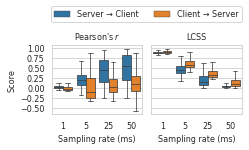

In [5]:
metric_label = {
    "pearsonr": "Pearson's $r$", 
    "spearmanr": "Spearman's $\\rho{}$",
    "lcss": "LCSS",
    "euclidean": "Scaled Euclidean"
}

def plot(data):
    fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(3.5, 1.8), squeeze=False)
    display(data.groupby(["metric", "Direction", RATE_COL]).median())
    
    for metric, ax in zip(["pearsonr", "lcss"], axes.ravel()):
        plot_data = data[data["metric"] == metric]
        sns.boxplot(data=plot_data, x=RATE_COL, y="Score", hue="Direction", showfliers=False, ax=ax, linewidth=0.75)
        ax.get_legend().remove()
        ax.set_title(metric_label[metric])
        
        ylim = ax.get_ylim()
        ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5, .75, 1.0])
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    handles, labels = ax.get_legend_handles_labels()
    if WITH_LEGEND:
        fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(.98, 1.15), ncol=2)
        
    for ax in axes.ravel():
        ax.set_ylim(ylim)
    
    for ax in axes[:, 1:].ravel():
        ax.set_ylabel(None)
    fig.tight_layout(h_pad=0.5)
        
    return fig

fig = plot(plot_data)
fig.savefig(OUTPUT_FILE.with_suffix(".png"), bbox_inches="tight", dpi=150)
fig.savefig(OUTPUT_FILE.with_suffix(".pgf"), backend="pgf", bbox_inches="tight")